In [97]:
#import libraries
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy import func, and_
from sqlalchemy import desc
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from flask import Flask, jsonify

In [5]:
#create an engine to connect to SQLite database
engine = create_engine("sqlite:////Users/dariareichkina/Projects/Bootcamp/sqlalcemy-challenge/SurfsUp/Resources/hawaii.sqlite")

In [6]:
#database tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station
Measurement = Base.classes.measurement


/var/folders/rb/y3r1w8zs1kg00_cgq7w_sg0w0000gn/T/ipykernel_13665/3238559000.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# view all of the classes that automap found
class_names = Base.classes.keys()
print(class_names)

['station', 'measurement']


In [8]:
# Save references to each table
metadata = MetaData()
hawaii_stations = Table('station', metadata, autoload_with=engine)
hawaii_measurement = Table('measurement', metadata, autoload_with=engine)

In [116]:
#create a session
session = Session(engine)


In [111]:
# calculate the latest date
latest_date = session.query(func.max(Measurement.date)).scalar()
# convert the latest_date string to a datetime object
latest_date = datetime.strptime(latest_date, "%Y-%m-%d")
# calculate the start date for the previous 12 months
start_date = latest_date - timedelta(days=366)
# create a subquery to get the precipitation data
subquery = session.query(Measurement.date, Measurement.prcp).filter(
    and_(Measurement.date >= start_date, Measurement.date <= latest_date)
).subquery()
# query the subquery for precipitation data
precipitation_data = session.query(subquery.c.date, subquery.c.prcp).all()
#results into DataFrame
df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])
df = df.sort_values("Date")

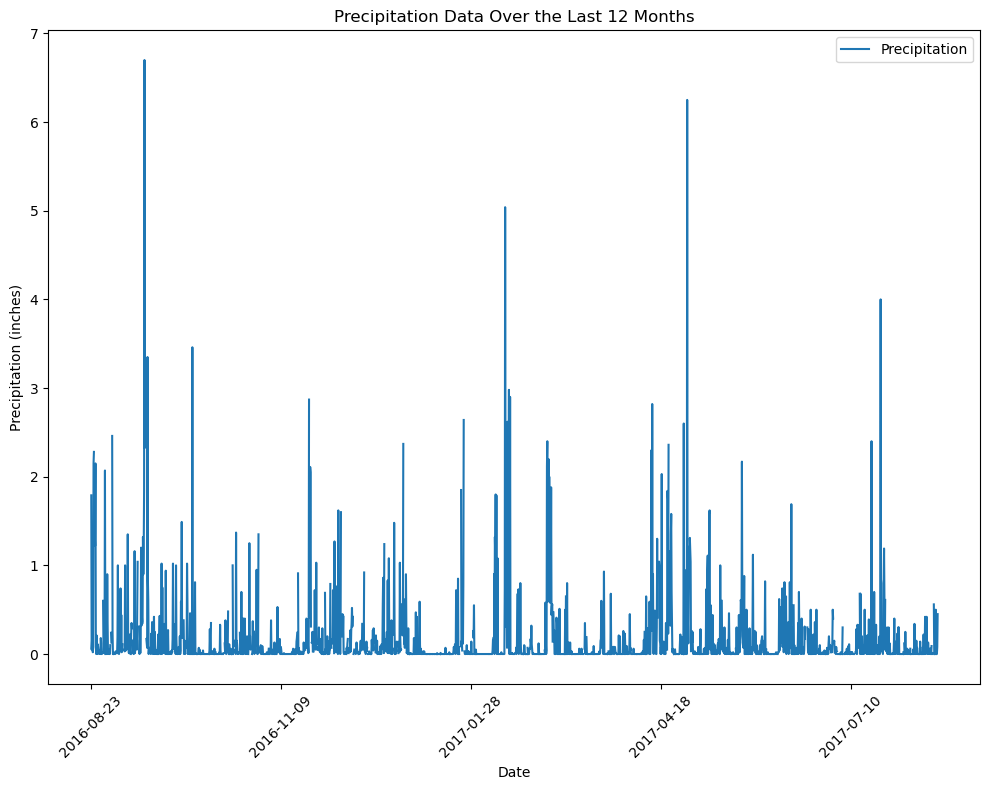

In [112]:
# plot the results
df.plot(x="Date", y="Precipitation", figsize=(10, 8))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Data Over the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [113]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [82]:
#station analysis
#total stations
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [107]:
#most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
list_stations = []
for station, count in active_stations:
    list_stations.append(station)
    print(f"Station: {station}, Observations: {count}")

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [114]:
#calculate the lowest, highest, and average temperature of the most popular station
ms = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0].station).one()
print(ms)

('USC00519281', 85.0, 54.0, 71.66378066378067)


In [109]:
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).first()[0]
#calculate the date 12 months from latest date
latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date = datetime.strptime(latest_date, "%Y-%m-%d")
one_year_ago = latest_date - timedelta(days=365)
#TOBS data for the most active station in the last 12 months
tobs_data = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).filter(Measurement.date <= latest_date).all()
#create DataFrame
df.tobs = pd.DataFrame(tobs_data, columns=['TOBS'])


/var/folders/rb/y3r1w8zs1kg00_cgq7w_sg0w0000gn/T/ipykernel_13665/857951202.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.tobs = pd.DataFrame(tobs_data, columns=['TOBS'])


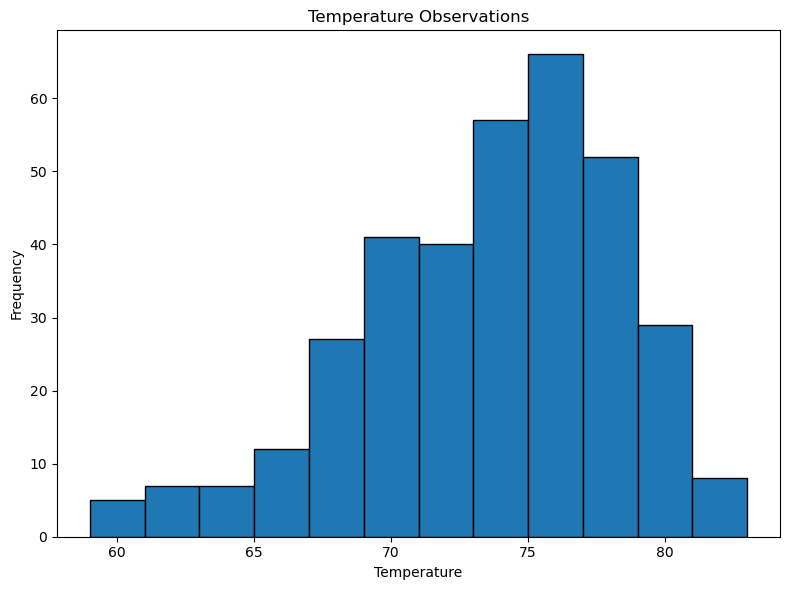

In [95]:
#create plot
plt.figure(figsize=(8, 6))
plt.hist(df['TOBS'], bins=12, edgecolor='black')
plt.title(f"Temperature Observations")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [119]:
# Create a Flask app
app = Flask('ClimateAnalysis')
# Homepage route
@app.route("/")
def home():
    return (
        "Welcome to the Climate Analysis API!<br/>"
        "Available Routes:<br/>"
        "/api/v1.0/precipitation<br/>"
        "/api/v1.0/stations<br/>"
        "/api/v1.0/tobs<br/>"
        "/api/v1.0/&lt;start&gt;<br/>"
        "/api/v1.0/&lt;start&gt/&lt;end&gt"
    )

# Route to retrieve precipitation data for the last 12 months
@app.route("/api/v1.0/precipitation")
def precipitation():
    json_precipitation = df.to_json(orient='records')
   
# Route to retrieve a list of stations
@app.route("/api/v1.0/stations")
def stations():
    json_station = json.dumps(list_stations)
    return json_station
   
# Route to retrieve temperature observations for the most active station in the last year
@app.route("/api/v1.0/tobs")
def tobs():
    # ('USC00519281', 85.0, 54.0, 71.66378066378067)
    keys = ("station", "max", "min", "avg")
    my_dict = dict(zip(keys, ms))
    return json.dumps(my_dict)
    
# Route to calculate TMIN, TAVG, and TMAX for a specified start date
@app.route("/api/v1.0/<start>")
def temp_start(start):
    startDateStatMetrics = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.date >= start).group_by(Measurement.station).all()
    return json.dumps(startDateStatMetrics)

# Route to calculate TMIN, TAVG, and TMAX for a specified start and end date
@app.route("/api/v1.0/<start>/<end>")
def temp_start_end(start, end):
    startEndDatesStationMetrics = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).filter(
        and_(Measurement.date >= start, Measurement.date <= end)
    ).group_by(Measurement.station).all()
    return json.dumps(startEndDatesStationMetrics)

# Run the app
if 'ClimateAnalysis' == '__main__':
    app.run(debug=True)


In [120]:
# Close Session
session.close()